In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product
import matplotlib.patches as patches

In [25]:
# energy specific fuel prices are not
SCENARIO = "dynamic" # "static" | "dynamic"

In [26]:
DATA = Path("..","data","processed", SCENARIO) # update name
FIGURES = Path("..","figures","ramping", SCENARIO) 
SECTORS = ["E", "H", "EH"]
PRICES = ["high", "mid", "low", "vlow"]
EMISSIONS = ["20", "35", "50"]
SECTOR_NICE_NAMES = {
    "E": "Electrical",
    "H": "Thermal",
    "EH": "Electrical\nand Thermal"
}
PRICE_NICE_NAMES = {
    "vlow": "Very\nLow",
    "low": "Low",
    "mid": "Mid",
    "high": "High"
}

In [27]:
def get_scenario_name(emission: str, sector: Optional[str] = None, price: Optional[str] = None) -> str:
    if not (sector or price):
        return f"er{emission}"
    else:
        return f"{sector}dr-{price}-er{emission}" 

In [28]:
def get_dataframe(emission: str, result: str, sector: Optional[str] = None, price: Optional[str] = None) -> pd.DataFrame:
    scenario = get_scenario_name(emission=emission, sector=sector, price=price)
    p = Path(DATA, scenario, "dataframe", f"{result}.csv")
    return pd.read_csv(p)

In [29]:
def get_ldc(emission: str, sector: Optional[str] = None, price: Optional[str] = None) -> pd.Series:
    scenario = get_scenario_name(emission=emission, sector=sector, price=price)
    df = get_dataframe(emission=emission, sector=sector, price=price, result="ramping")
    return df[["Absolute 3-hr Ramping"]].rename(columns={"Absolute 3-hr Ramping":scenario}).squeeze().sort_values(ascending=False)

In [30]:
def get_data() -> dict[str,pd.DataFrame]:
    data = {}
    for emission in EMISSIONS:
        dfs = []
        dfs.append(get_ldc(emission).to_frame(name="base"))
        for sector, price in product(SECTORS, PRICES):
            df = get_ldc(emission, sector, price).to_frame()
            dfs.append(df)
        data[f"er{emission}"] = pd.concat(dfs, axis=1)
    return data

In [31]:
def generate_ldc(emission: str, include_title: bool = True, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    data = get_data()
    
    ncols = 2
    nrows = 1
    
    color_map = {
        "base": "k",
        "Edr": "tab:purple", 
        "Hdr": "tab:orange", 
        "EHdr": "tab:green", 
    }

    linestyle_map = {
        "base": "-",
        "high": "-",
        "mid": "--",
        "low": "-.",
        "vlow": ":",
    }

    
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))
    
    title = kwargs.get("title", "")
    if title:
        fig.suptitle(title, fontsize=20)
    
    df = data[emission]
    
    upper = df.max().max()
    lower = df.max().min()
    
    for col in df.columns:
        
        if col == "base":
            sector = "base"
            price = "base"
            label = "No DR"
        else:
            sector = col.split("-")[0]
            price = col.split("-")[1]
            label = f"{sector}-{price}"
        
        color = color_map[sector]
        linestyle = linestyle_map[price]
    
        df[col].plot(ax=axs[0], label=label, color=color, linestyle=linestyle)
        df[col].plot(ax=axs[1], xlim=(0,50), ylim=(lower-6000, upper+2000), label=label, color=color, linestyle=linestyle)
        
    
    rectangle = patches.Rectangle(
        (-10, lower-3000),  # (x, y) of bottom-left corner
        25, # Width of the rectangle
        (upper + 2000) - (lower - 2000),       # Height of the rectangle
        linewidth=2, 
        edgecolor='red', 
        facecolor='none',
        zorder=99
    )
    axs[0].add_patch(rectangle)
    
    
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles, 
        labels, 
        loc="center left", 
        bbox_to_anchor=(1, 0.5),  # Position to the right of the figure
        ncol=1, 
        frameon=False,
    )
    
    if include_title:
        fig.suptitle(f"{emission[-2:]}% Net Load Ramping Duration Curve", fontsize=20)
        
    fig.supxlabel("Day of Year")
    fig.supylabel("Maximum Daily 3hr Net Load Ramp (MW)")
        
    plt.tight_layout(rect=[0, 0, 1, 0.99])
        
    return fig, axs

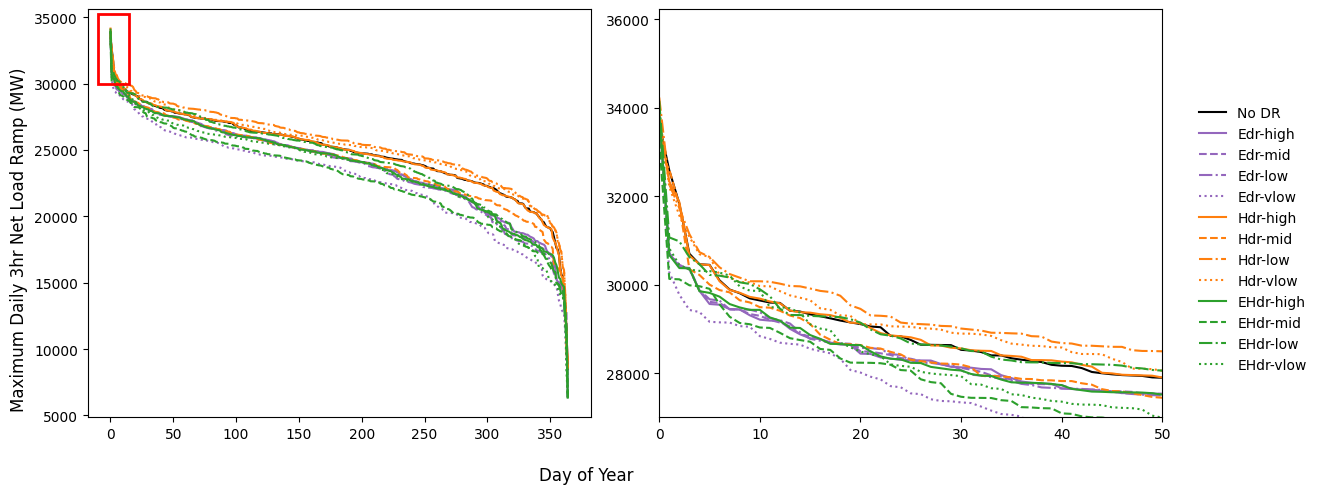

In [32]:
fig, _ = generate_ldc("er20", include_title=False)
fig.savefig(Path(FIGURES, "er20.png"), bbox_inches="tight")

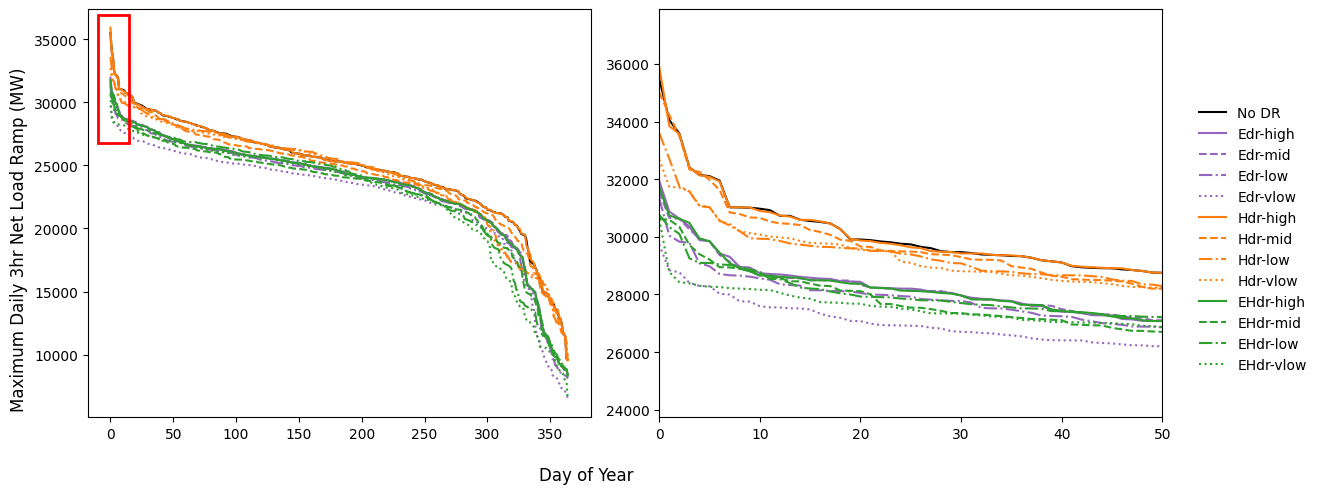

In [33]:
fig, _ = generate_ldc("er35", include_title=False)
fig.savefig(Path(FIGURES, "er35.png"), bbox_inches="tight")

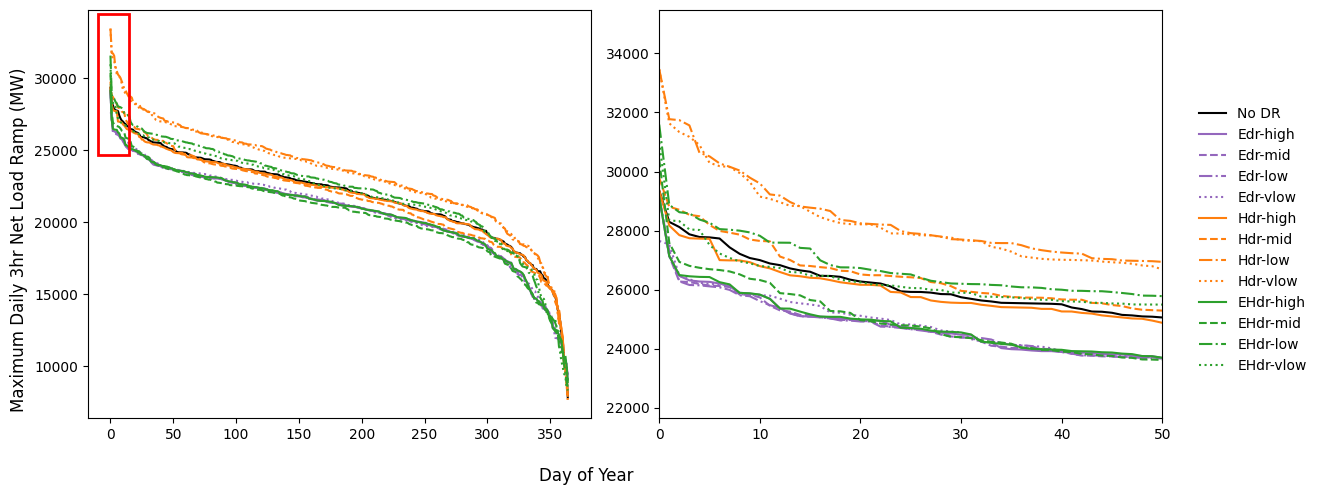

In [34]:
fig, _ = generate_ldc("er50", include_title=False)
fig.savefig(Path(FIGURES, "er50.png"), bbox_inches="tight")